---
date: 2023-03-20
title: Haldane model
date-format: short
---

In [1]:
import kwant
from matplotlib import pyplot as plt
import tinyarray as ta
import numpy as np
import scipy.sparse.linalg as sla
import scipy

from numpy import cos, exp, pi, sqrt, sin, sinh, cosh
from numpy import linalg as LA
from scipy.sparse import diags

from scipy.linalg import eigvals

In this project we would like to demonstrate Haldane model. It is an example of a bicatomic honeycomb lattice. The idea proposed by Haldane was to indroduce complex next-neighbour amplitude.

First of all we create our system. As we mentioned before it is lattice with two atomes in cell and with two different hoppings. We put onsite equal to zero. For convenience we also define matrix R so we can easily rotate the whole system. At the end we add left and right lead making the system infinite.

In [2]:
def make_system(a=1, t_1=1.0, t_2=1.0, L=10, r=3):
    R = np.array([[np.sqrt(3)/2, 1/2],[-1/2, np.sqrt(3)/2]])
    #R = np.array([[1, 0], [0,1]])
    v_1 = [3*a/2, np.sqrt(3)*a/2]
    v_2 = [3*a/2, -np.sqrt(3)*a/2]
    
    r_1 = [0,0]
    r_2 = [a,0]
    
    lat = kwant.lattice.Polyatomic([np.dot(R,v_1), np.dot(R,v_2)], [np.dot(R,r_1), np.dot(R,r_2)],norbs=1)
    lat.a, lat.b = lat.sublattices
    
    syst = kwant.Builder()
    # Onsites
    onsite = 0
    syst[(lat.a(n, m) for n in range(L) for m in range(L))] = onsite
    syst[(lat.b(n, m) for n in range(L) for m in range(L))] = onsite
    # Hopping
    hoppings = (((0, a), lat.a, lat.b), 
                ((a, 0), lat.a, lat.b), 
                ((-a/2, -np.sqrt(3)*a/2), lat.a, lat.b),
                ((-a/2, np.sqrt(3)*a/2), lat.a, lat.b))
    syst[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] = t_1
    hoppings2_a = (((0, a), lat.a, lat.a), ((a, 0), lat.a, lat.a), ((a, -a), lat.a, lat.a))
    #hoppings2_a = (((a/2, 3*a/2), lat.a, lat.a))
    hoppings2_b = (((0, a), lat.b, lat.b), ((a, 0), lat.b, lat.b), ((a, -a), lat.b, lat.b))
    syst[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings2_a]] = t_2
    syst[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings2_b]] = t_2

    # Right lead
    sym_right_lead = kwant.TranslationalSymmetry(np.dot(R,[-3*a/2, -np.sqrt(3)*a/2]))
    right_lead = kwant.Builder(sym_right_lead)
    right_lead[(lat.a(n, m) for n in range(L) for m in range(L))] = onsite
    right_lead[(lat.b(n, m) for n in range(L) for m in range(L))] = onsite
    # Right lead hopping
    right_lead[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] = t_1
    right_lead[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings2_a]] = t_2
    right_lead[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings2_b]] = t_2

    syst.attach_lead(right_lead)
    right_lead_fin = right_lead.finalized()
    syst.attach_lead(right_lead.reversed())
    syst_fin = syst.finalized()
    
    return syst_fin, right_lead_fin

Here we define few functions which will help us plot some of the system's parameters

In [3]:
def plot_bandstructure(flead, momenta, label=None, title=None):
    bands = kwant.physics.Bands(flead)
    energies = [bands(k) for k in momenta]
    
    plt.figure()
    plt.title(title)
    plt.plot(momenta, energies, label=label)
    plt.xlabel("momentum [(lattice constant)^-1]")
    plt.ylabel("energy [t]")

def plot_conductance(syst, energies):
    # Compute conductance
    data = []
    for energy in energies:
        smatrix = kwant.smatrix(syst, energy)
        data.append(smatrix.transmission(1, 0))

    plt.figure()
    plt.plot(energies, data)
    plt.xlabel("energy [t]")
    plt.ylabel("conductance [e^2/h]")
    plt.show()

def plot_density(sys,ener, it=-1):
    wf = kwant.wave_function(sys, energy=ener)
    t = np.shape(wf(0))
    nwf = wf(0)[0]*0
    
    for i in range(t[0]//2+1):
        test=wf(0)[i]
        nwf+=test

    psi=abs(nwf)**2
    kwant.plotter.map(sys, psi, method='linear', vmin=0)
    J_0 = kwant.operator.Current(sys)
    c = J_0(nwf)
    kwant.plotter.current(sys, c)
    plt.close()

Now, let's see how the system look like

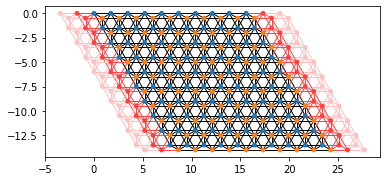

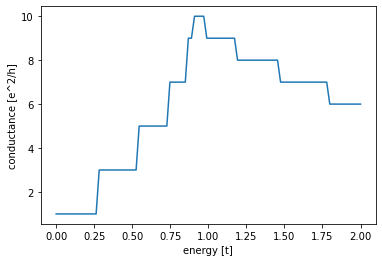

/usr/local/anaconda3/envs/kwant/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: The plotted data contains 0.87% of values overflowing upper limit 1.3598 


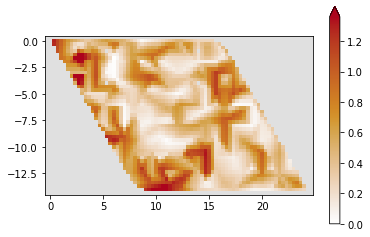

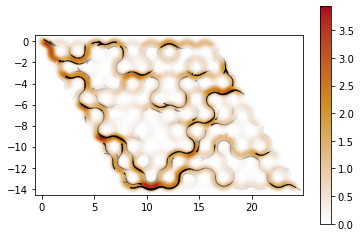

/usr/local/anaconda3/envs/kwant/lib/python3.6/site-packages/ipykernel_launcher.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


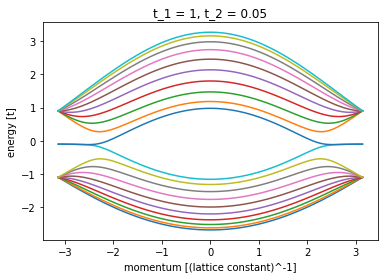

In [8]:
t_2 = 0.05
sys, right_lead = make_system(t_1 = 1, t_2 = t_2)
kwant.plot(sys)
plot_conductance(sys, np.linspace(0,2,100))
plot_density(sys, 1)
plot_bandstructure(right_lead, np.linspace(-np.pi, np.pi, 100), t_2, title=f"t_1 = 1, t_2 = {t_2}")

We can compare simulated results to the analitical model. For this puropuse let's define proper hamiltonian and show both, simulated and calculated, results.

In [9]:
# Odwrotna transformata
def H0(kx, t_2):
    h = 8*np.sin(np.pi*np.sqrt(3)/2) * (np.sqrt(3)/2 * np.cos(3/2 * kx) + 1j*np.sin(3/2 * kx))
    h += -np.sqrt(3) * np.sin(np.pi * np.sqrt(3))
    h += 8*np.sin(np.pi * np.sqrt(3)/2) *  (np.sqrt(3)/2 * np.cos(-3/2*kx) + 1j*np.sin(-3/2 * kx))
    return 2 * abs(t_2) * np.cos(np.angle(t_2)) * h/np.sqrt(2*np.pi)

def Hz(kx, t_2):
    h = -8*np.sin(np.pi * np.sqrt(3)/2) * (np.cos(3/2 * kx) + 1j*np.sqrt(3)/2*np.sin(3/2 * kx))
    h += -np.sin(-np.sqrt(3)*np.pi)
    h += -8*np.sin(np.pi *  np.sqrt(3)/2) * (np.cos(-3/2 * kx) + 1j*np.sqrt(3)/2*np.sin(-3/2 * kx))
    return 2j * abs(t_2) * np.sin(np.angle(t_2)) * h/np.sqrt(2*np.pi)

def Hx(kx, t_1):
    h = 8*np.sin(-np.pi*np.sqrt(3)/2) * (-np.sqrt(3)/2*np.cos(-kx/2) + 1j*np.sin(-kx/2))
    h += 8*np.sin(np.pi*np.sqrt(3)/2) * (np.sqrt(3)/2*np.cos(-kx/2) + 1j*np.sin(-kx/2))
    return t_1 * h /np.sqrt(2*np.pi)

def Hy(kx, t_1):
    h = 8*np.sin(-np.pi*np.sqrt(3)/2) * (np.cos(-kx/2) - 1j*np.sqrt(3)/2*np.sin(-kx/2))
    h += 8*np.sin(np.pi*np.sqrt(3)/2) * (np.cos(-kx/2) + 1j*np.sqrt(3)/2*np.sin(-kx/2))
    return -t_1 * 1j * h/np.sqrt(2*np.pi)

def E_plus(kx, t_1, t_2):
    return H0(kx, t_2) + np.sqrt(Hx(kx, t_1)**2 + Hy(kx, t_1)**2 + Hz(kx, t_2)**2)

def E_minus(kx, t_1, t_2):
    return H0(kx, t_2) - np.sqrt(Hx(kx, t_1)**2 + Hy(kx, t_1)**2 + Hz(kx, t_2)**2)

def matH(kx, t_1, t_2, phi):
    M = 0.2
    phi = phi*pi
    return [[2*np.real(t_2)*np.cos(np.sqrt(3)*kx+phi), 2*t_1*np.cos(np.sqrt(3)/2*kx)], [2*t_1*np.cos(np.sqrt(3)/2*kx), 2*np.real(t_2)*np.cos(np.sqrt(3)*kx-phi)]]

def sparseMat(kx, t_1, t_2, phi, s):
    kx = kx/sqrt(3)
    phi = phi*pi
    A1 = diags([1], [0], shape=(s,s)).toarray()
    B1 = np.kron(A1, matH(kx, t_1, t_2, phi))
    
    A2 = diags([1], [1], shape=(s,s)).toarray()
    a=2*np.real(t_2)*np.cos((np.sqrt(3)/2)*kx-phi)
    b=2*np.real(t_2)*np.cos((np.sqrt(3)/2)*kx+phi)
    
    B2 = np.kron(A2, [[a, t_1], [0, b]])
    
    A3 = diags([1], [-1], shape=(s,s)).toarray()

    #B3 = np.kron(A3, [[a, t_1], [0, b]])
    B3 = np.kron(A3, [[a, 0], [t_1, b]])
    return np.add(np.add(B1, B2), B3)

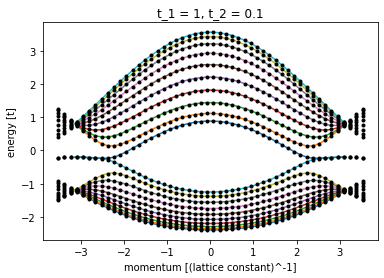

In [17]:
def plot_bandstructure(flead, momenta, label=None, title=None):
    bands = kwant.physics.Bands(flead)
    energies = [bands(k) for k in momenta]
    
    fig, ax = plt.subplots()
    plt.title(title)
    ax.plot(momenta, energies, label=label)
    plt.xlabel("momentum [(lattice constant)^-1]")
    plt.ylabel("energy [t]")
    return ax

t_2 = 0.1
sys, right_lead = make_system(t_1 = 1, t_2 = t_2)
ax = plot_bandstructure(right_lead, np.linspace(-np.pi, np.pi, 100), t_2, title=f"t_1 = 1, t_2 = {t_2}")

M = 0.0

kx = np.linspace(-2*np.pi/sqrt(3)+0.1, 2*np.pi/sqrt(3)-0.1, 50)
bands = [(np.real(LA.eigvalsh(sparseMat(x, 1, t_2, 0, 10)))) for x in kx]
ax.plot(kx,bands,color='black',marker=".",linestyle="None")
plt.show()